In [5]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import stats
from utils.read_files import read_from_control, make_default_path
from pathlib import Path
import numpy as np

In [6]:
# set control file
controlFile = "control_EastRiver.txt"

In [7]:
# open the benchmark data
path_to_benchmark = read_from_control(controlFile, 'benchmark')

# Specify default path if needed
if path_to_benchmark == 'default':  
    path_to_benchmark = make_default_path('benchmark/for_prism_anomalies', controlFile) # outputs a Path()
else:
    path_to_benchmark = Path(path_to_benchmark) # make sure a user-specified path is a Path()

# get file names from the output path
benchmark_file_names = os.listdir(path_to_benchmark)

In [104]:
# open each file 
for file in benchmark_file_names:
    if "TEMP" in file:
        temp_df = pd.read_csv(path_to_benchmark / file, index_col=0, parse_dates=True, names=['Temperature'], header=None, skiprows=1).resample("MS").sum()
    elif "PPT" in file:
        ppt_df = pd.read_csv(path_to_benchmark / file, index_col=0, parse_dates=True, names=['Precipitation'], header=None, skiprows=1).resample("MS").sum()

In [191]:
# create the climatology between water years 1981-2010
temp_clim = temp_df.loc['1981-10-01':'2010-09-30']
ppt_clim = ppt_df.loc['1981-10-01':'2010-09-30']

# calculate the mean and standard deviation for each month 
temp_clim_mean = temp_clim.groupby(temp_clim.index.month).mean()
temp_clim_std = temp_clim.groupby(temp_clim.index.month).std()
ppt_clim_mean = ppt_clim.groupby(ppt_clim.index.month).mean()
ppt_clim_std = ppt_clim.groupby(ppt_clim.index.month).std()


/home/dlhogan/miniforge3/envs/pysumma/lib/python3.9/site-packages/matplotlib/transforms.py:2652: RuntimeWarning: divide by zero encountered in scalar divide
  x_scale = 1.0 / inw
/home/dlhogan/miniforge3/envs/pysumma/lib/python3.9/site-packages/matplotlib/transforms.py:2654: RuntimeWarning: invalid value encountered in scalar multiply
  self._mtx = np.array([[x_scale, 0.0    , (-inl*x_scale)],


(535.0, 548.0)

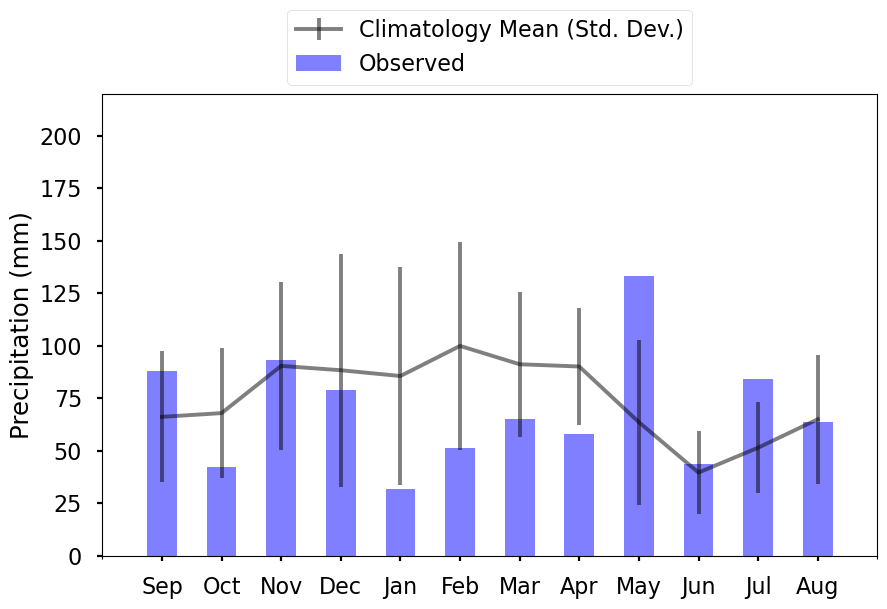

In [202]:

year=2015
dry_warm_spring_example = ppt_df[f"{year-1}-09-01":f"{year}-08-31"]
clim_mean = ppt_clim_mean['Precipitation'].loc[[9,10,11,12,1,2,3,4,5,6,7,8]]
clim_mean.index = dry_warm_spring_example.index
clim_std = ppt_clim_std['Precipitation'].loc[[9,10,11,12,1,2,3,4,5,6,7,8]]
clim_std.index = dry_warm_spring_example.index

plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10,6))

clim_mean.plot(ax=ax, color='black', label='Climatology Mean (Std. Dev.)', yerr=clim_std, alpha=0.5)
ax.bar(dry_warm_spring_example.index, dry_warm_spring_example['Precipitation'], color='blue', label='Observed', alpha=0.5, align='center', width=-0.5)




# # shade Mar-May
# ax.axvspan(f'{year}-03-01', f'{year}-06-01', color='green', alpha=0.25,label='Spring')
# # shade Sep-Nov
# ax.axvspan(f'{year-1}-08-31', f'{year-1}-12-01', color='orange', alpha=0.25,label='Fall')

ax.set_ylim(0,220)
ax.set_ylabel('Precipitation (mm)')
ax.legend(ncols=1, bbox_to_anchor=(0.5,1.1), loc='center')

ax.set_xticks(dry_warm_spring_example.index)
ax.set_xticklabels(dry_warm_spring_example.index.strftime('%b'))
# add xticks to beginning of month
ax.set_xlim(f'{year-1}-08-01', f'{year}-09-30')

<Axes: title={'center': 'Precipitation Climatology'}>

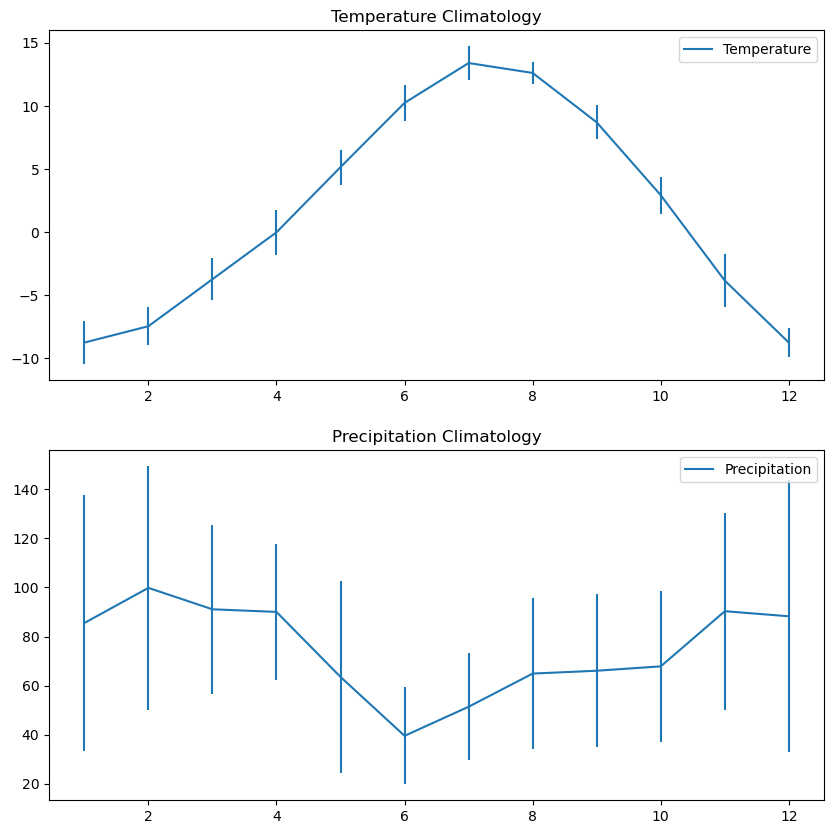

In [65]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
temp_clim_mean.plot(ax=ax[0], yerr=temp_clim_std, title='Temperature Climatology')
ppt_clim_mean.plot(ax=ax[1], yerr=ppt_clim_std, title='Precipitation Climatology')


In [66]:
# calculate the anomalies for each month
temp_anom = (temp_df - temp_clim_mean.loc[temp_df.index.month].set_index(temp_df.index)) / temp_clim_std.loc[temp_df.index.month].set_index(temp_df.index)
ppt_anom = -(ppt_df - ppt_clim_mean.loc[ppt_df.index.month].set_index(ppt_df.index)) / ppt_clim_std.loc[ppt_df.index.month].set_index(ppt_df.index)

In [67]:
# average to each year's seasonal cycle
temp_anom_norm_seasonal = temp_anom.resample('QS-Sep').mean()
ppt_anom_norm_seasonal = ppt_anom.resample('QS-Sep').mean()

# merge the dataframes
anom_norm_seasonal = pd.concat([temp_anom_norm_seasonal, ppt_anom_norm_seasonal], axis=1)

/tmp/ipykernel_23760/1789181552.py:2: FutureWarning: 'QS-Sep' is deprecated and will be removed in a future version, please use 'QS-SEP' instead.
  temp_anom_norm_seasonal = temp_anom.resample('QS-Sep').mean()
/tmp/ipykernel_23760/1789181552.py:3: FutureWarning: 'QS-Sep' is deprecated and will be removed in a future version, please use 'QS-SEP' instead.
  ppt_anom_norm_seasonal = ppt_anom.resample('QS-Sep').mean()


In [68]:
spring_anom_norm = anom_norm_seasonal.loc[anom_norm_seasonal.index.month == 3]
summer_anom_norm = anom_norm_seasonal.loc[anom_norm_seasonal.index.month == 6]
fall_anom_norm = anom_norm_seasonal.loc[anom_norm_seasonal.index.month == 9]
winter_anom_norm = anom_norm_seasonal.loc[anom_norm_seasonal.index.month == 12]

# shift the fall year index by 1
fall_anom_norm.index = fall_anom_norm.index + pd.DateOffset(years=1)

In [69]:
#restructure for heatmap
winter_anom_norm = winter_anom_norm.pivot_table(index=winter_anom_norm.index.year, columns=winter_anom_norm.index.month, values=['Temperature', 'Precipitation'])
spring_anom_norm = spring_anom_norm.pivot_table(index=spring_anom_norm.index.year, columns=spring_anom_norm.index.month, values=['Temperature', 'Precipitation'])
summer_anom_norm = summer_anom_norm.pivot_table(index=summer_anom_norm.index.year, columns=summer_anom_norm.index.month, values=['Temperature', 'Precipitation'])
fall_anom_norm = fall_anom_norm.pivot_table(index=fall_anom_norm.index.year, columns=fall_anom_norm.index.month, values=['Temperature', 'Precipitation'])

# drop the multi-index columns
winter_anom_norm.columns = winter_anom_norm.columns.droplevel(1)
spring_anom_norm.columns = spring_anom_norm.columns.droplevel(1)
summer_anom_norm.columns = summer_anom_norm.columns.droplevel(1)
fall_anom_norm.columns = fall_anom_norm.columns.droplevel(1)

In [70]:
# filter to 1980 - 2024
winter_anom_norm = winter_anom_norm.loc[1980:2024]
spring_anom_norm = spring_anom_norm.loc[1980:2024]
summer_anom_norm = summer_anom_norm.loc[1980:2024]
fall_anom_norm = fall_anom_norm.loc[1980:2024]


In [71]:
# sort top 10 driest, wettest, warmest, and coldest years
spring_top_10_driest = spring_anom_norm.sort_values(by=['Precipitation']).head(5)
spring_top_10_wettest = spring_anom_norm.sort_values(by=['Precipitation'], ascending=False).head(5)
# merge the top 10 driest and wettest years
spring_top_10_ppt = pd.concat([spring_top_10_driest, spring_top_10_wettest])

spring_top_10_warmest = spring_anom_norm.sort_values(by=['Temperature'], ascending=False).head(5)
spring_top_10_coldest = spring_anom_norm.sort_values(by=['Temperature']).head(5)
# merge the top 10 warmest and coldest years
spring_top_10_temp = pd.concat([spring_top_10_warmest, spring_top_10_coldest])

In [72]:
# sort top 10 driest, wettest, warmest, and coldest years
fall_top_10_driest = fall_anom_norm.sort_values(by=['Precipitation']).head(5)
fall_top_10_wettest = fall_anom_norm.sort_values(by=['Precipitation'], ascending=False).head(5)
# merge the top 10 driest and wettest years
fall_top_10_ppt = pd.concat([fall_top_10_driest, fall_top_10_wettest])

fall_top_10_warmest = fall_anom_norm.sort_values(by=['Temperature'], ascending=False).head(5)
fall_top_10_coldest = fall_anom_norm.sort_values(by=['Temperature']).head(5)
# merge the top 10 warmest and coldest years
fall_top_10_temp = pd.concat([fall_top_10_warmest, fall_top_10_coldest])



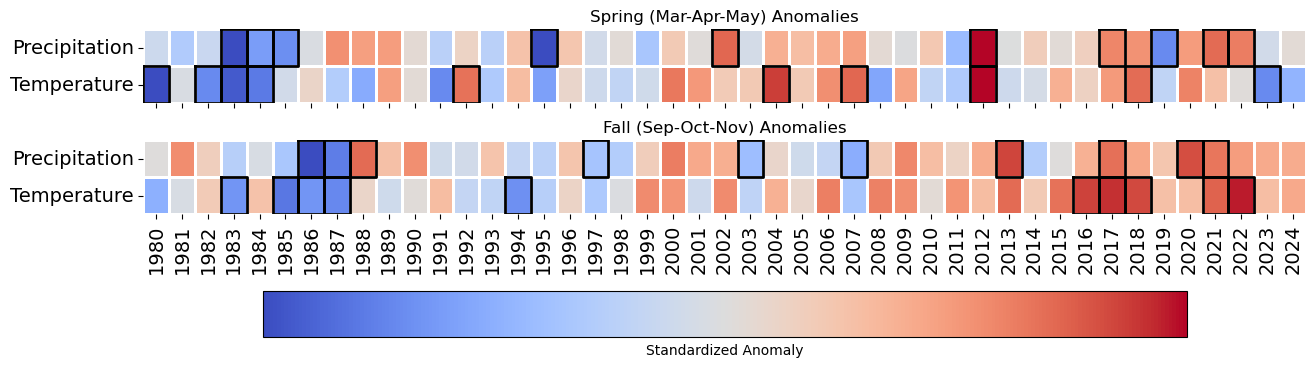

In [73]:
# make a heatmap for each season for each year
fig, ax = plt.subplots(2, 1, figsize=(15, 4), sharex=True)
# add vertical space
plt.subplots_adjust(hspace=0.5)
sns.heatmap(spring_anom_norm.T, ax=ax[0], cmap='coolwarm', center=0,
            vmin=-1.5, vmax=1.5,
            # add spines
            linecolor='white',
            linewidth=1,
            cbar=False)
ax[0].set_title('Spring (Mar-Apr-May) Anomalies')
cax = sns.heatmap(fall_anom_norm.T, ax=ax[1], cmap='coolwarm', center=0,
            vmin=-1.5, vmax=1.5,
            # add spines
            linecolor='white',
            linewidth=1,
            cbar=False)
ax[1].set_title('Fall (Sep-Oct-Nov) Anomalies')

# create colorbar
cbar = plt.colorbar(cax.collections[0], ax=ax, orientation='horizontal', pad=0.25)
cbar.set_label('Standardized Anomaly')
# remove ticks on the colorbar
cbar.set_ticks([])
# show every year on the x-axis
ax[0].set_xticks(range(0, len(spring_anom_norm.index)));
ax[0].set_xticklabels(spring_anom_norm.index);
ax[1].set_xticks(np.arange(0.5, len(fall_anom_norm.index)+0.5, 1));
ax[1].set_xticklabels(fall_anom_norm.index, ha='center');
# add black borders to the heatmap

for a in ax:
    a.set_xlim(0, len(spring_anom_norm.index))

# year look up
spring_year_dict = dict(zip(spring_anom_norm.index, range(0, len(spring_anom_norm.index))))
spring_year_dict[2025] = len(spring_anom_norm.index) +1

fall_year_dict = dict(zip(fall_anom_norm.index, range(0, len(fall_anom_norm.index))))
fall_year_dict[2025] = len(fall_anom_norm.index) +1

def draw_box(ax, year, year_dict, color, var_name):
    if var_name == 'Temperature':
        y = [1, 2, 2, 1, 1]
    else:
        y = [0, 1, 1, 0, 0]    
    ax.plot([year_dict[year], year_dict[year], year_dict[year+1], year_dict[year+1], year_dict[year]], y, color, lw=2)
    return


# add boxes over major years
for year in spring_top_10_ppt.index:
    draw_box(ax[0], year, spring_year_dict, 'black', 'Precipitation')
for year in spring_top_10_temp.index:
    draw_box(ax[0], year, spring_year_dict, 'black', 'Temperature')
for year in fall_top_10_ppt.index:
    draw_box(ax[1], year, fall_year_dict, 'black', 'Precipitation')
for year in fall_top_10_temp.index:
    draw_box(ax[1], year, fall_year_dict, 'black', 'Temperature')
    

# increse the size of the xaixs labels
for a in ax:
    a.tick_params(axis='x', labelrotation=90)
    a.tick_params(axis='x', labelsize=14)
    a.tick_params(axis='y', labelsize=14)
